<a href="https://colab.research.google.com/github/drw02/CIVE610-Porject/blob/main/CIVE610_Project_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clone repo
!git clone https://github.com/drw02/CIVE610-Porject.git
%cd /content/CIVE610-Porject

Cloning into 'CIVE610-Porject'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.
/content/CIVE610-Porject


In [ ]:
# import libraries needed
import numpy as np
import matplotlib.pyplot as plt
import math

##Units



*   SI: N, mm, celsius
*   US: Kips, in, Fahrenheit



#1. TRUSS ANALYSIS

##1.1 LINEAR ANALYSIS

 Input parameters



*   COORD: the joint coordinates of the structure
*   MSUP: the support data of each joint, following same order of joints in COORD. (Rx,Ry) where "0" indicates no restraint and "1" indicates a restraint
*   MPRP: member connectivity (starting joint, ending joint)
*   EM: member modulud of elsticity, follows same order of members in MPRP
*   CP: cross-sectional area of each member, follows same order of members in MPRP
*   PJ: joint external loads, follows same order of joint in COORD







In [ ]:
# change input data below to define structure

# Joint Data
COORD = np.array([[0,0],[192,0],[96,72],[96,144]]) # create coordinate matrix
NJ=np.size(COORD, 0)

# Support Data
MSUP = np.array([[1,1],[1,1],[0,0],[1,1]]) # support data matrix MSUP in order of joints

# Member Data
MPRP=np.array([[1,3],[2,3],[3,4]]) # starting joint, end joint # in order of memebers

# Material Property (E)
EM = np.array([[1300],[1300],[1300]]) # insert in order of members

# Cross-Sectional Property
CP= np.array([[2],[2],[1]]) # insert in order of members

# Load Data
PJ=np.array([[0,0],[0,0],[400,-800],[0,0]]) # insert in order of joints

Get global stiffness matrix fo structure

In [ ]:
# get global stiffness matrix of truss structure
from truss_global_stiffness import truss_global_stiffness
glob_k = truss_global_stiffness(COORD, MPRP, EM, CP)

Split the global stiffness matrix

In [ ]:
# this functions splits global stiffness matrix
from truss_k_split import split_matrix
kff, kcc, kfc, kcf, ff, cc = split_matrix(glob_k, MSUP)

Get all joint loads and displacements

In [ ]:
# get force and displacement vectors
from truss_f_d import truss_f_d
F, U = truss_f_d(glob_k, kff, kcf, MSUP, PJ, ff, cc)

Plot deformed shape

In [ ]:
# get deformed coordinates of truss
from truss_deformed import deformed_COORD
COORD_new = deformed_COORD(COORD, U)

# get coordinates for truss system
from plot_COORD import  get_plot_COORD
COORD_plot = get_plot_COORD(COORD, MPRP)
x = COORD_plot[:,0] # collect x coordinates
y = COORD_plot[:,1] # collect y coordinates

# get coordinates for truss deformed shape
COORD_new_plot = get_plot_COORD(COORD_new, MPRP)
x_new = COORD_new_plot[:,0] 
y_new = COORD_new_plot[:,1]

# Plotting both the curves simultaneously
plt.plot(x, y, color='r', label='original')
plt.plot(x_new, y_new, color='g', label='deformed')

plt.legend()
plt.show()

##1.2 NonLinear

 Input parameters



*   COORD: the joint coordinates of the structure
*   MSUP: the support data of each joint, following same order of joints in COORD. (Rx,Ry) where "0" indicates no restraint and "1" indicates a restraint
*   MPRP: member connectivity (starting joint, ending joint)
*   EM: member modulud of elsticity, follows same order of members in MPRP
*   CP: cross-sectional area of each member, follows same order of members in MPRP
*   PJ: joint external loads, follows same order of joint in COORD







In [ ]:
# Joint Data
COORD = np.array([[0,0],[192,0],[96,72],[96,144]]) # create coordinate matrix
NJ=np.size(COORD, 0)

# Support Data
MSUP = np.array([[1,1],[1,1],[0,0],[1,1]]) # support data matrix MSUP in order of joints

# Member Data
MPRP=np.array([[1,3],[2,3],[3,4]]) # starting joint, end joint # in order of memebers

# Material Property (E)
EM = np.array([[1300],[1300],[1300]]) # insert in order of members

# Cross-Sectional Property
CP= np.array([[2],[2],[1]]) # insert in order of members

# Load Data
PJ=np.array([[0,0],[0,0],[400,-800],[0,0]]) # insert in order of joints

Get global stiffness matrix of structure with n consideration to geometric non-linearity

In [ ]:
# get global stiffness matrix of truss structure
from truss_global_stiffness import truss_global_stiffness
glob_k_e = truss_global_stiffness(COORD, MPRP, EM, CP) # elastic behavior

Split stiffness matrix

In [ ]:
# this functions splits global stiffness matrix
from truss_k_split import split_matrix
kff_e, kcc_e, kfc_e, kcf_e, ff, cc = split_matrix(glob_k_e, MSUP)

Get joint forces and displacements

In [ ]:
# get force and displacement vectors
from truss_f_d import truss_f_d
F, Uprev = truss_f_d(glob_k_e, kff_e, kcf_e, MSUP, PJ, ff, cc)

Iterate to get actual displacemnts with specified tolerance

In [ ]:
# specify tolerance at which you need the aieration to stop
tolerance = 0.001

In [ ]:
tol = 1

while tol >= tolerance:

    # get new deformed coordinates of truss
    from truss_deformed import deformed_COORD
    COORD_new = deformed_COORD(COORD, Uprev)

    # start ietartions here ...

    # get global parameters
    from truss_global_stiffness_NL import truss_global_stiffness_NL
    glob_k, glob_f = truss_global_stiffness_NL(COORD_new, COORD, MPRP, EM, CP)

    # split matrix 
    from truss_k_split import split_matrix
    kff, kcc, kfc, kcf, ff, cc = split_matrix(glob_k, MSUP)

    # split force vector
    f_ff = glob_f[ff]

    # split applied force vector
    fr = []
    for row in PJ:
        for i in row:
            fr.append(i)

    fr = np.transpose(np.array([fr]))
    fr_ff = fr[ff]

    # subtract forces

    f = np.subtract(fr_ff,f_ff)

    delta_d = np.dot(np.linalg.inv(kff), f)

    u = Uprev[ff]
    u = np.transpose(u)
    u = np.reshape(u, (len(ff),1))

    tol = math.sqrt( np.sum(delta_d*delta_d)/np.sum(u*u))

    u_ = np.add(delta_d,u)

    uf_list = u_.tolist()

    U=[0] * (len(ff)+len(cc))

    for x, y in zip(uf_list, ff):
        U[y]=x[0]

    Uprev=np.array(U)

Plot deformed shape

In [ ]:
# plot deformed shape

COORD_new = deformed_COORD(COORD, Uprev)

# get coordinates for truss system
from plot_COORD import  get_plot_COORD
COORD_plot = get_plot_COORD(COORD, MPRP)
x = COORD_plot[:,0] # collect x coordinates
y = COORD_plot[:,1] # collect y coordinates


# get coordinates for truss deformed shape
COORD_new_plot = get_plot_COORD(COORD_new, MPRP)
x_new = COORD_new_plot[:,0] 
y_new = COORD_new_plot[:,1]


# Plotting both the curves simultaneously
plt.plot(x, y, color='r', label='original')
plt.plot(x_new, y_new, color='g', label='deformed')

plt.legend()
plt.show()

###2. FRAME/BEAM ANALYSIS

 Input parameters



*   COORD: the joint coordinates of the structure
*   MSUP: the support data of each joint, following same order of joints in COORD. (Rx,Ry, Mz) where "0" indicates no restraint and "1" indicates a restraint
*   MPRP: member connectivity (starting joint, ending joint)
*   EM: member modulud of elsticity, follows same order of members in MPRP
*   CP: cross-sectional area of each member, follows same order of members in MPRP
*   IP: moment of inertia of each member, follows same order of members in MPRP
*   MR: moment releases for each member, "0" indicates no release and "1" indicates a moment release. (starting joint of memebr, ending joint of member)
*   PJ: joint external loads, follows same order of joint in COORD


Load data

1. Concentrated load: (a,p) where a is distance from the starting joint of the member to the load, and p is the load value [downwards is positive]
2. Concentrated moment: (a, m) where a is distance from the starting joint of the member to the load, and m is the moment value [counter clockwise is positive]
3. Distributed uniform load: (a, b, w) where a is the distance from the strating joint of the member to the midpoint of the distributed laod, b is the length of the distributed load, and w is the distributed load value
4. Thermal load: (alpha factor, Tupper, Tlower, h) where the alpha factor is the thremal expansion factor, Tupper is the temperature at the top of the member, Tlower is the temperature at the bottom of the member, h is the height of the member
5. Support Settlement (settlement at start, setllement at end).


All loads input follows are specified for each individula member with same order of members in MRPR
Tool can only handle one of the load types 1 to 3 on a member. If more than one is specified diagrams plotted will be not consistent with results.


**Note:** When a moment release is defined, make sure to set a restraint over Mz at that same joint. This will not effect results, however it will ensure that the tool will not run into any singular matrix error.

In [ ]:
# Joint Data
COORD = np.array([[0,0],[8000,0],[13000,0]]) # create coordinate matrix
NJ=np.size(COORD, 0)

# Support Data
MSUP = np.array([[0,1,0],[0,1,0],[1,1,1]]) # Rx,Ry,Mz

# Material Property (E)
EM = np.array([[200],[200]]) # insert in order of members

# Cross-Sectional Property
CP= np.array([[6000],[4000]]) # insert in order of members

# Inertia Property
IP= np.array([[200000000],[50000000]]) # insert in order of members

# Member Data
MPRP=np.array([[1,2],[2,3]]) # starting joint, end joint # in order of memebers

# Moment releases
MR = np.array([[0,0],[0,0]]) # each row represents a member with each column represetning a node with value "1" for releases

# Load Data
# this apllication will take into consideration three type of loads P, M, and W
P=np.array([[0, 0],[2000,20]]) # (a, p) and order is in order of members
M=np.array([[4000, 3500],[0,0]]) # (a, M) and order is in order of members
W=np.array([[0, 0, 0],[0,0,0]]) # (a, d, W) and order is in order of members
Th=np.array([[0,0,0,400],[0,0,0,400]]) # aplha factor, Tupper, Tlower, h 
                                       # h cannot be 0 always assume a randome value if not given

# Load settlement data
Delta = np.array([[0,0],[0,0]]) # make sure that settlement is defined consistently thoughout the member

# Load joint external loads
PJ = np.array([[0,0,0],[0,0,0],[0,0,0]]) # Fx, Fy, Mz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Get global stiffness matrix and favricated forces vector of structure

In [ ]:
# get global stiffness matrix of truss structure
from frame_global_stiffness import frame_global_stiffness
glob_K, Ff = frame_global_stiffness(COORD, MPRP, EM, CP, IP, P, M ,W , Th, Delta, MR)

/content/CIVE610-Porject/frame_data_input.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Delta = np.array([[0,0],[0,0,0]]) # make sure that settlement is defined consistently thoughout the member


Split global stiffness matrix and fabticated forces vector

In [ ]:
#  this functions splits global stiffness matrix
from frame_k_split import split_matrix
kff, kcc, kfc, kcf, ff, cc = split_matrix(glob_K, MSUP)

# this functions splits the fabriacted forces
from frame_fabricated_split import split_fabricated
Ff_c, Ff_f = split_fabricated(ff ,cc, Ff)

Get joint forces and diplacements

In [ ]:
# get displacement and forces vectors
from frame_f_d import frame_f_d
F, U = frame_f_d(kff, glob_K, Ff_f, PJ, ff, cc , Ff)

Plot V, M, slope, deflection diagrams

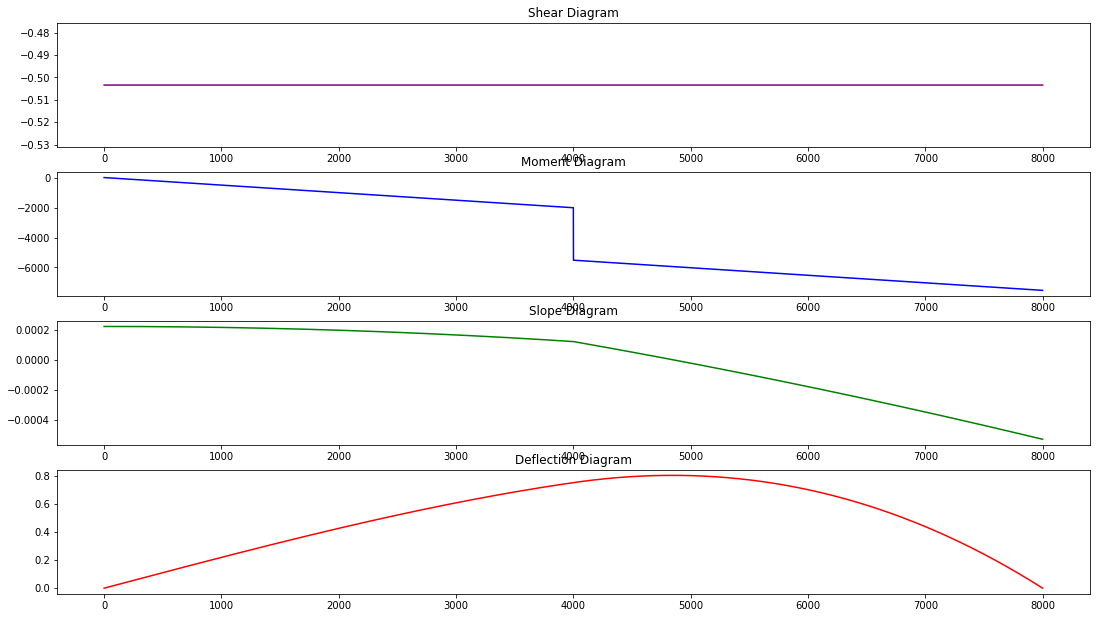

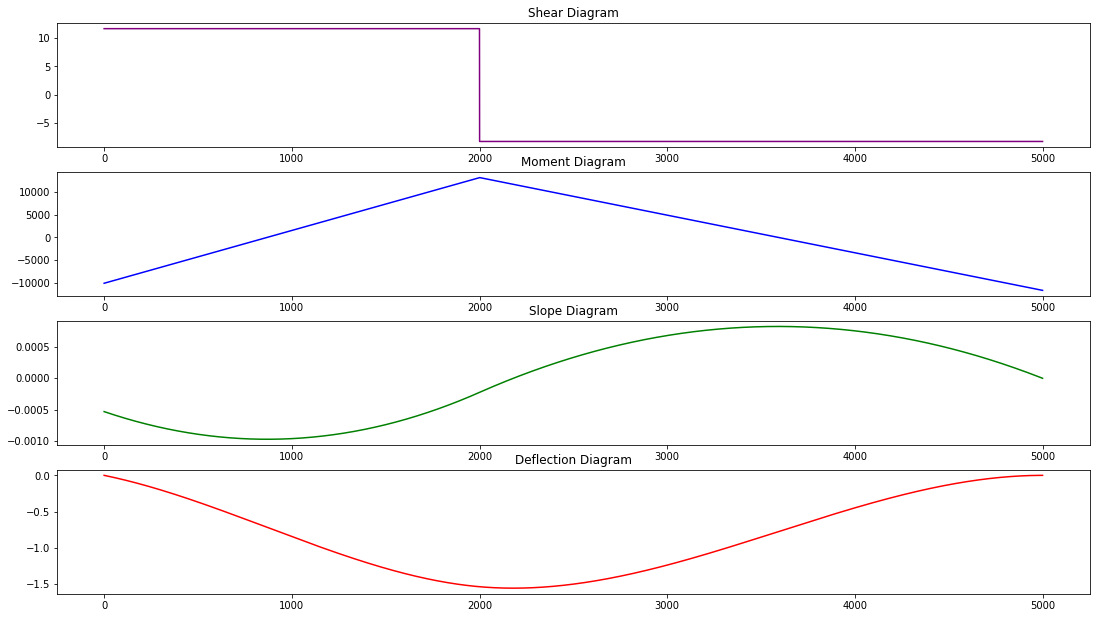

In [ ]:
# plot moment displacement and slope diagrams
from frame_element_diagram import frame_elemt_diagram
frame_elemt_diagram(COORD, MPRP, EM, CP, IP, P, M ,W , F, U, Th, Delta, MR)

###3. Report Errors

To report any erro encounter in the tool kindly refer to the following link:
https://github.com/drw02/CIVE610-Porject/issues

###4. References



*   https://github.com/drw02/CIVE610-Porject
*   A. Kassimali, Structural Analysis. Cengage Learning, 2009.





